In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from scipy import signal
from scipy import fft
from scipy import interpolate
from scipy import stats

plt.rcParams["figure.figsize"]=10,5

In [3]:
def my_round(X , DX) :

    if np.log10(DX)>0 : 
        Ndecimal = 1 - np.int(np.ceil(np.abs(np.log10(DX))))
    else : 
        Ndecimal = np.int(np.ceil(np.abs(np.log10(DX))))
    
    if Ndecimal == 0 : 
        DX = np.int(np.around( DX , Ndecimal ))
        X = np.int(np.around( X , Ndecimal ))
    else : 
        DX = np.around( DX , Ndecimal )
        X = np.around( X , Ndecimal )
        
    return X , DX



def Affine(P,x) :
    return P[0] * x + P[1]

#########################

Période du pendule simple

#########################

In [4]:
ls -lrt

total 43984
-rw-r--r--@ 1 Johany  staff    54898 May  4 17:26 coniques.pdf
-rw-r--r--@ 1 Johany  staff    11016 May  4 21:59 orbite.jpeg
-rw-r--r--@ 1 Johany  staff  3297078 May  4 22:13 Orbites.jpg
-rw-r--r--@ 1 Johany  staff    22243 May  4 22:27 Sideral.png
-rw-r--r--@ 1 Johany  staff    42471 May  4 22:56 Emin.pdf
-rw-r--r--  1 Johany  staff     6977 May  4 22:57 Epeff.pdf
-rw-r--r--@ 1 Johany  staff        0 May  8 18:59 Icon?
-rwxr-xr-x  1 Johany  staff    27396 May  9 18:20 scope_1_1.csv*
-rw-r--r--  1 Johany  staff   253013 May  9 22:15 Untitled.ipynb
-rw-r--r--  1 Johany  staff      103 May  9 22:47 Mass_Freq_Pendule.csv
-rw-r--r--  1 Johany  staff      103 May  9 22:48 rdy2go.txt
-rw-r--r--  1 Johany  staff  1621274 May 10 15:42 LP01.ipynb
-rw-r--r--@ 1 Johany  staff  5317706 May 11 18:58 Diapo.pdf
-rwxr-xr-x@ 1 Johany  staff  9934903 May 11 18:58 Diapo.key*


In [5]:
# Formatage du fichier csv le cas echeant : 
catinit= open('scope_1_1.csv','r').read()
print (catinit)

x,1
second,Volt
-20,-1.64968463934961
-19.95,-1.16194537436616
-19.9,-0.53331491764794
-19.85,0.159982412380264
-19.8,0.833881143099026
-19.75,1.40666797079009
-19.7,1.80888987249419
-19.65,1.99177560274396
-19.6,1.93314943017142
-19.55,1.64012004637504
-19.5,1.14821860454591
-19.45,0.517090404613249
-19.4,-0.176737372208116
-19.35,-0.849134934198612
-19.3,-1.41857100121509
-19.25,-1.8159988453575
-19.2,-1.99322852256725
-19.15,-1.92877012378004
-19.1,-1.63043952470119
-19.05,-1.13441067512428
-19,-0.500829342047797
-18.95,0.193479839698215
-18.9,0.864328705844974
-18.85,1.43037376270474
-18.8,1.82297945787031
-18.75,1.99454055490463
-18.7,1.92425448601943
-18.65,1.620643758577
-18.6,1.12052256208787
-18.55,0.484532879333309
-18.5,-0.210208631441658
-18.45,-0.879461384095931
-18.4,-1.44207542100368
-18.35,-1.82983121662161
-18.3,-1.99571160701765
-18.25,-1.91960283606872
-18.2,-1.61073344039713
-18.15,-1.10655524709096
-18.1,-0.468202168353567
-18.05,0.226922564996356
-18,0.89453189932

In [6]:
catinit=catinit.replace(',',' ') #Delimiter 


cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [7]:
# Lecture du fichier Formate 
Cat = np.genfromtxt('rdy2go.txt',dtype=[('t',np.float) , ('U',np.float)],skip_header=2)


<IPython.core.display.Javascript object>


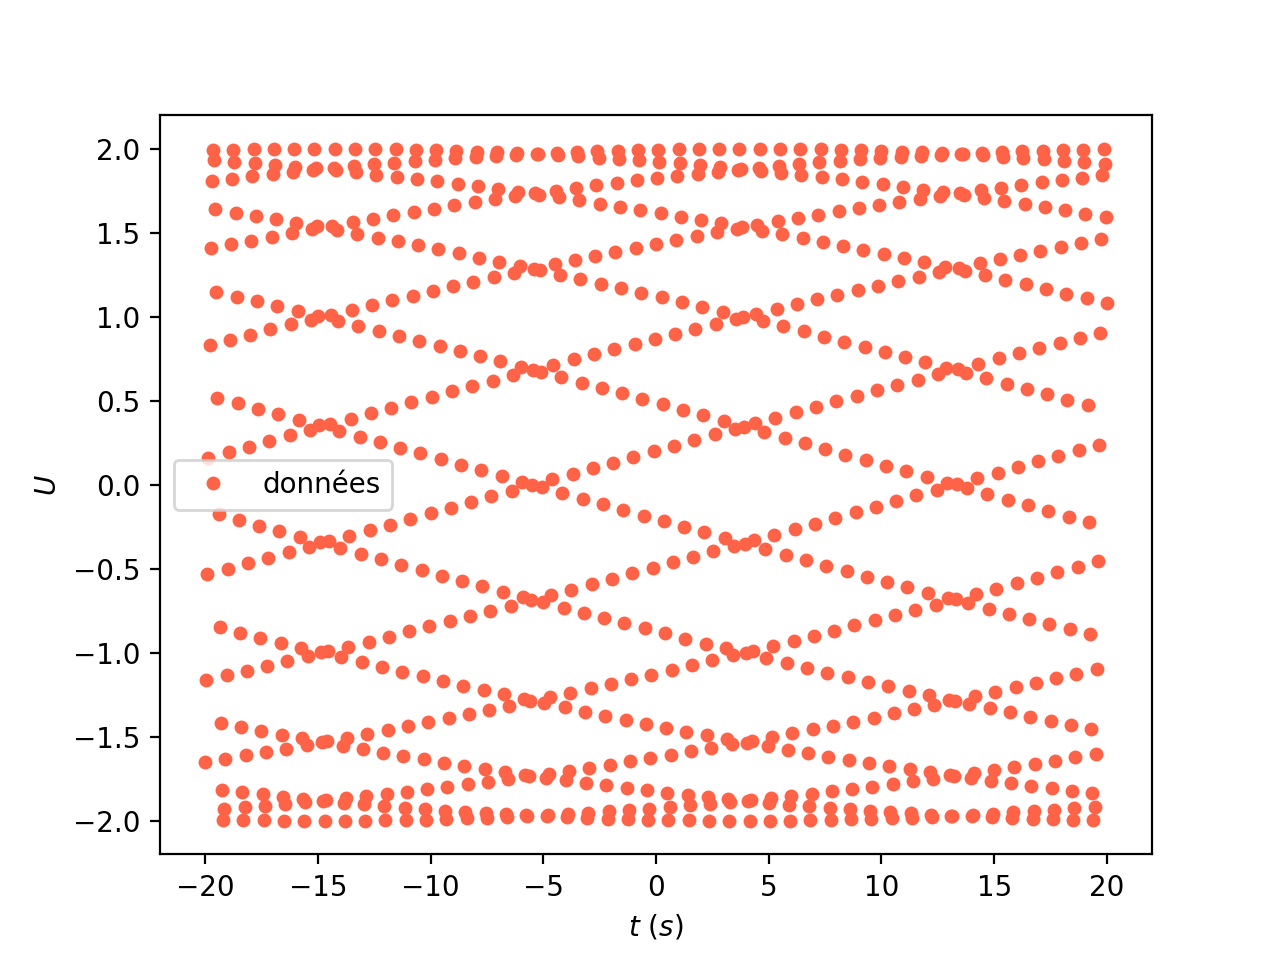

In [8]:
# Plot Data : 


%matplotlib notebook
plt.figure()

plt.xlabel('$t\ (s)$')
plt.ylabel('$U$')

plt.errorbar( Cat['t'] , Cat['U'], color='tomato', fmt = 'o',markersize=4,label='données')


plt.legend()
plt.show()


In [9]:
#### fft to get frequence : 

# supression de la partie continue : 
Cat['U'] = Cat['U'] - ( np.max(Cat['U']) + np.min(Cat['U']))/2.
t0 = Cat['t'][0]
Cat['t'] = Cat['t'] - t0
#

N = len(Cat['t'])   # Nombre de point 
fe = (N-1.) / (Cat['t'][-1] - Cat['t'][0]) # Frequence d'échantillonage

zeros=np.zeros(5*N)

echantillons_z = np.concatenate((Cat['U'],zeros))
X = fft.fft(echantillons_z)  # FFT du signal

N_z=len(echantillons_z)
#fpos=np.arange(N_z)*fe/N_z
fpos = np.linspace(0., fe/2., np.int(N_z/2)) # Les fréquences (Positive, sinon il faudrait faire de -N/2 à N/2) associé à la discrétisation de la FFT
Xpos = X[0:np.int(N_z/2)] # Seulement les valeurs associés aux fréquences positives


In [10]:
########## Recherche de la fréquence principale 

f = interpolate.interp1d(fpos, abs(Xpos),kind='quadratic')
x=np.arange(fpos[0],fpos[-1],0.0001)
y= f(x)

fbest = x[np.argmax(y)]

for i in range(0,len(fpos)) : 
    if fpos[i] >= fbest : 
        locate_sup = i
        break

phi = ((fpos[locate_sup]-fbest)/(fpos[locate_sup]-fpos[locate_sup-1])) * np.angle(Xpos)[locate_sup-1] + ((fbest-fpos[locate_sup-1])/(fpos[locate_sup]-fpos[locate_sup-1])) * np.angle(Xpos)[locate_sup] # Utilisation de la regle des segments inverses pour estimer la valeur du déphasage entre les 2 fréquence proches de fbest




<IPython.core.display.Javascript object>


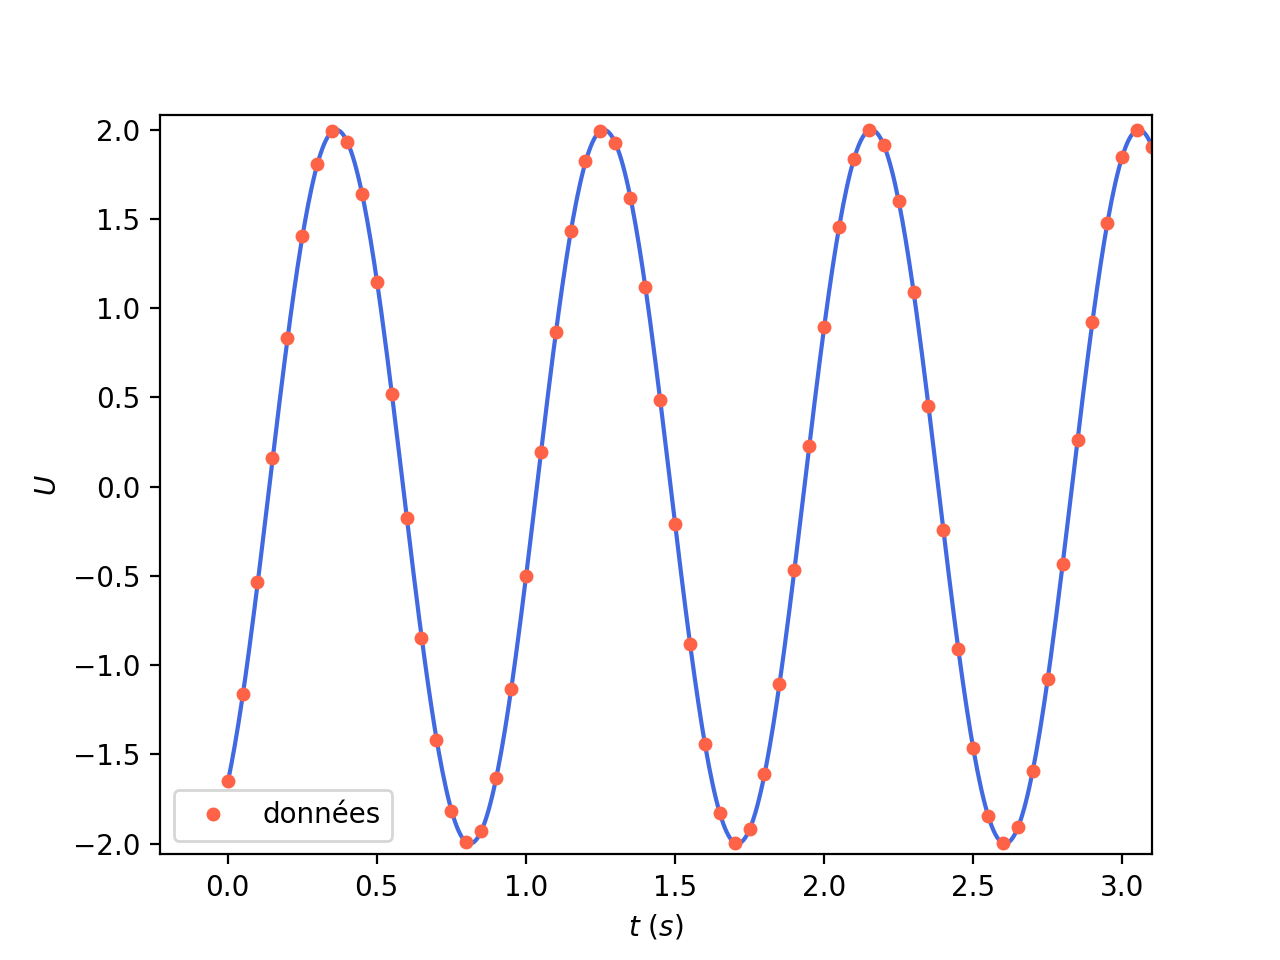

La frequence est de : f=1.1146 +/- 0.002081598667776796 Hz


In [11]:
# Plot Data : 

X = Cat['t']
Xrange = 1.5*(np.max(X) - np.min(X))
Xmin = (np.max(X) + np.min(X))/2. - 0.5*Xrange
Xmax = (np.max(X) + np.min(X))/2. + 0.5*Xrange
Xplot = np.arange(max(Xmin,0),Xmax,Xrange/10000.)

fit = np.max(Cat['U']) * np.cos(2*np.pi*fbest*Xplot + phi ) # Signal associé

### Full fft plot
#Sum = np.sum(np.abs(Xpos))
#fit = np.zeros(len(Cat['t']))

#for i in range(0,len(abs(Xpos))) : 
#    fit = fit + (np.abs(Xpos)[i]/Sum)*np.cos(2*np.pi*fpos[i]*Cat['t'] + np.angle(Xpos)[i]) 
#
#fit = (np.max(Cat['U'])/ np.max(fit) )* fit
    
%matplotlib notebook
plt.figure()

plt.xlabel('$t\ (s)$')
plt.ylabel('$U$')

plt.errorbar( Cat['t'] , Cat['U'], color='tomato', fmt = 'o',markersize=4,label='données')
plt.plot(Xplot , fit , color='royalblue')

plt.legend()
plt.show()

print('La frequence est de : f='+str(fbest)+' +/- '+str((fpos[locate_sup]-fpos[locate_sup-1])/2.)+' Hz')
#print('La phase est de : $\phi$='+str(phi)+'+/- '+str( np.abs((np.angle(Xpos)[locate_sup-1] - np.angle(Xpos)[locate_sup-1])/2.)  )+' rad')

In [18]:
# Alternative dans le cas où on ai pas accés au signal 
T = np.float(input('Durée de la mesure (s)'))
Terr = np.float(input('Incertitude sur la mesure (s)'))
Nperiod = np.float(input('Nombre de periodes'))

frequence = Nperiod / T
f_Err = frequence * (Terr/T)

print('La frequence est de : f='+str(frequence)+' +/- '+str(f_Err)+' Hz')


Durée de la mesure (s)9.0
Incertitude sur la mesure (s)0.5
Nombre de periodes10
La frequence est de : f=1.1111111111111112 +/- 0.06172839506172839 Hz


In [20]:
ls -lrt

total 32592
-rw-r--r--@ 1 Johany  staff    54898 May  4 17:26 coniques.pdf
-rw-r--r--@ 1 Johany  staff    11016 May  4 21:59 orbite.jpeg
-rw-r--r--@ 1 Johany  staff  3297078 May  4 22:13 Orbites.jpg
-rw-r--r--@ 1 Johany  staff    22243 May  4 22:27 Sideral.png
-rw-r--r--@ 1 Johany  staff    42471 May  4 22:56 Emin.pdf
-rw-r--r--  1 Johany  staff     6977 May  4 22:57 Epeff.pdf
-rw-r--r--@ 1 Johany  staff        0 May  8 18:59 Icon?
-rwxr-xr-x  1 Johany  staff    27396 May  9 18:20 scope_1_1.csv*
-rw-r--r--  1 Johany  staff   253013 May  9 22:15 Untitled.ipynb
-rw-r--r--  1 Johany  staff    27396 May  9 22:31 rdy2go.txt
-rwxr-xr-x@ 1 Johany  staff  9401610 May  9 22:44 Diapo.key*
-rw-r--r--  1 Johany  staff  1446763 May  9 22:45 LP01.ipynb
-rw-r--r--  1 Johany  staff      103 May  9 22:47 Mass_Freq_Pendule.csv


In [21]:
# Formatage du fichier csv le cas echeant : 
catinit= open('Mass_Freq_Pendule.csv','r').read()
print (catinit)

Masse,Frequence,F_err
10,1.11,0.06
20,1.05,0.07
50,1.17,0.06
100,1.10,0.06
110,1.08,0.07
150,1.09,0.07



In [22]:
catinit=catinit.replace(',',' ') #Delimiter 

cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [23]:
# Lecture du fichier Formate 
Cat = np.genfromtxt('rdy2go.txt',dtype=[('m',np.float) , ('f',np.float) , ('f_err',np.float)],skip_header=1)

<IPython.core.display.Javascript object>


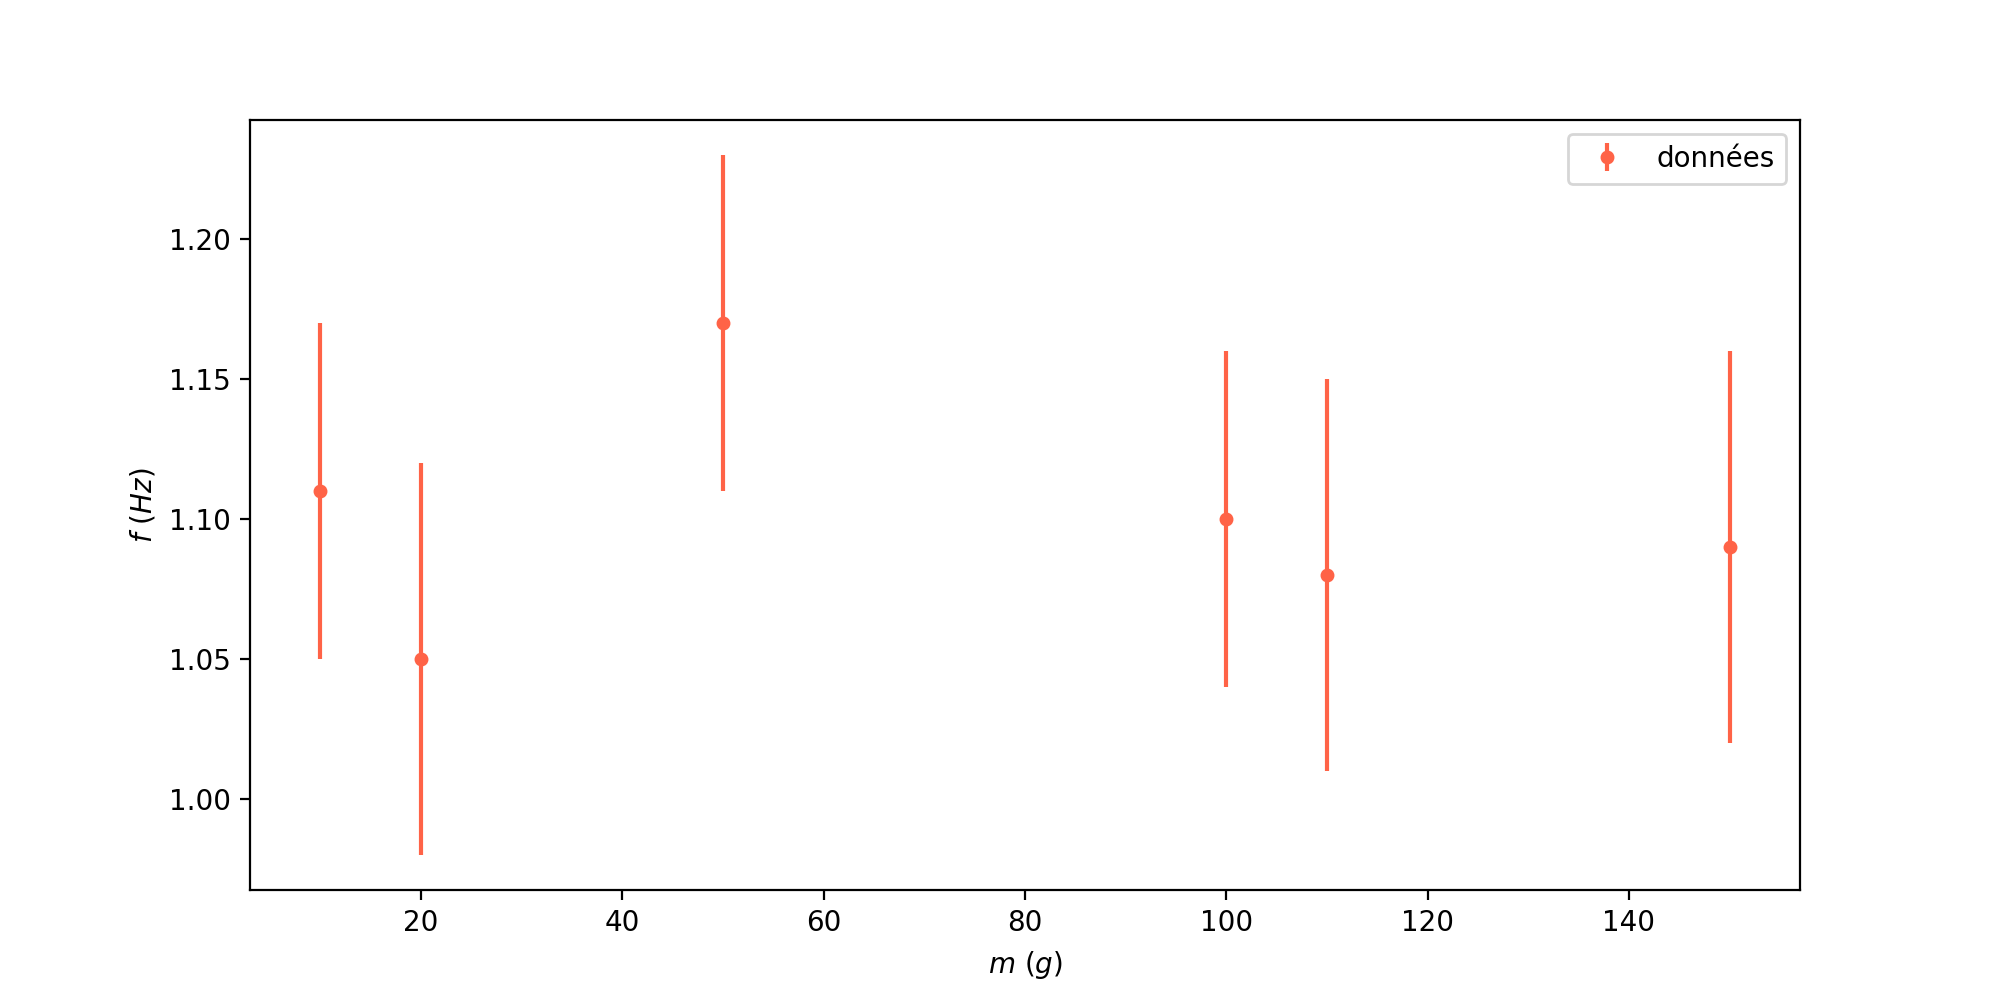

-0.09931832879575933 | Pearson Correlation coefficient : proche de -1 et 1 signifie fortement corrélé, proche de 0 signifie fortement décorélé


In [32]:
%matplotlib notebook
plt.figure()

plt.xlabel('$m\ (g)$')
plt.ylabel('$f \ (Hz)$')

plt.errorbar( Cat['m'] , Cat['f'], yerr=Cat['f_err'] , color='tomato', fmt = 'o',markersize=4,label='données')

plt.legend()
plt.show()

print( str(stats.pearsonr(Cat['m'], Cat['f'])[0])+' | Pearson Correlation coefficient : proche de -1 et 1 signifie fortement corrélé, proche de 0 signifie fortement décorélé' )


#######################

Energie potentielle effective

#######################

<IPython.core.display.Javascript object>


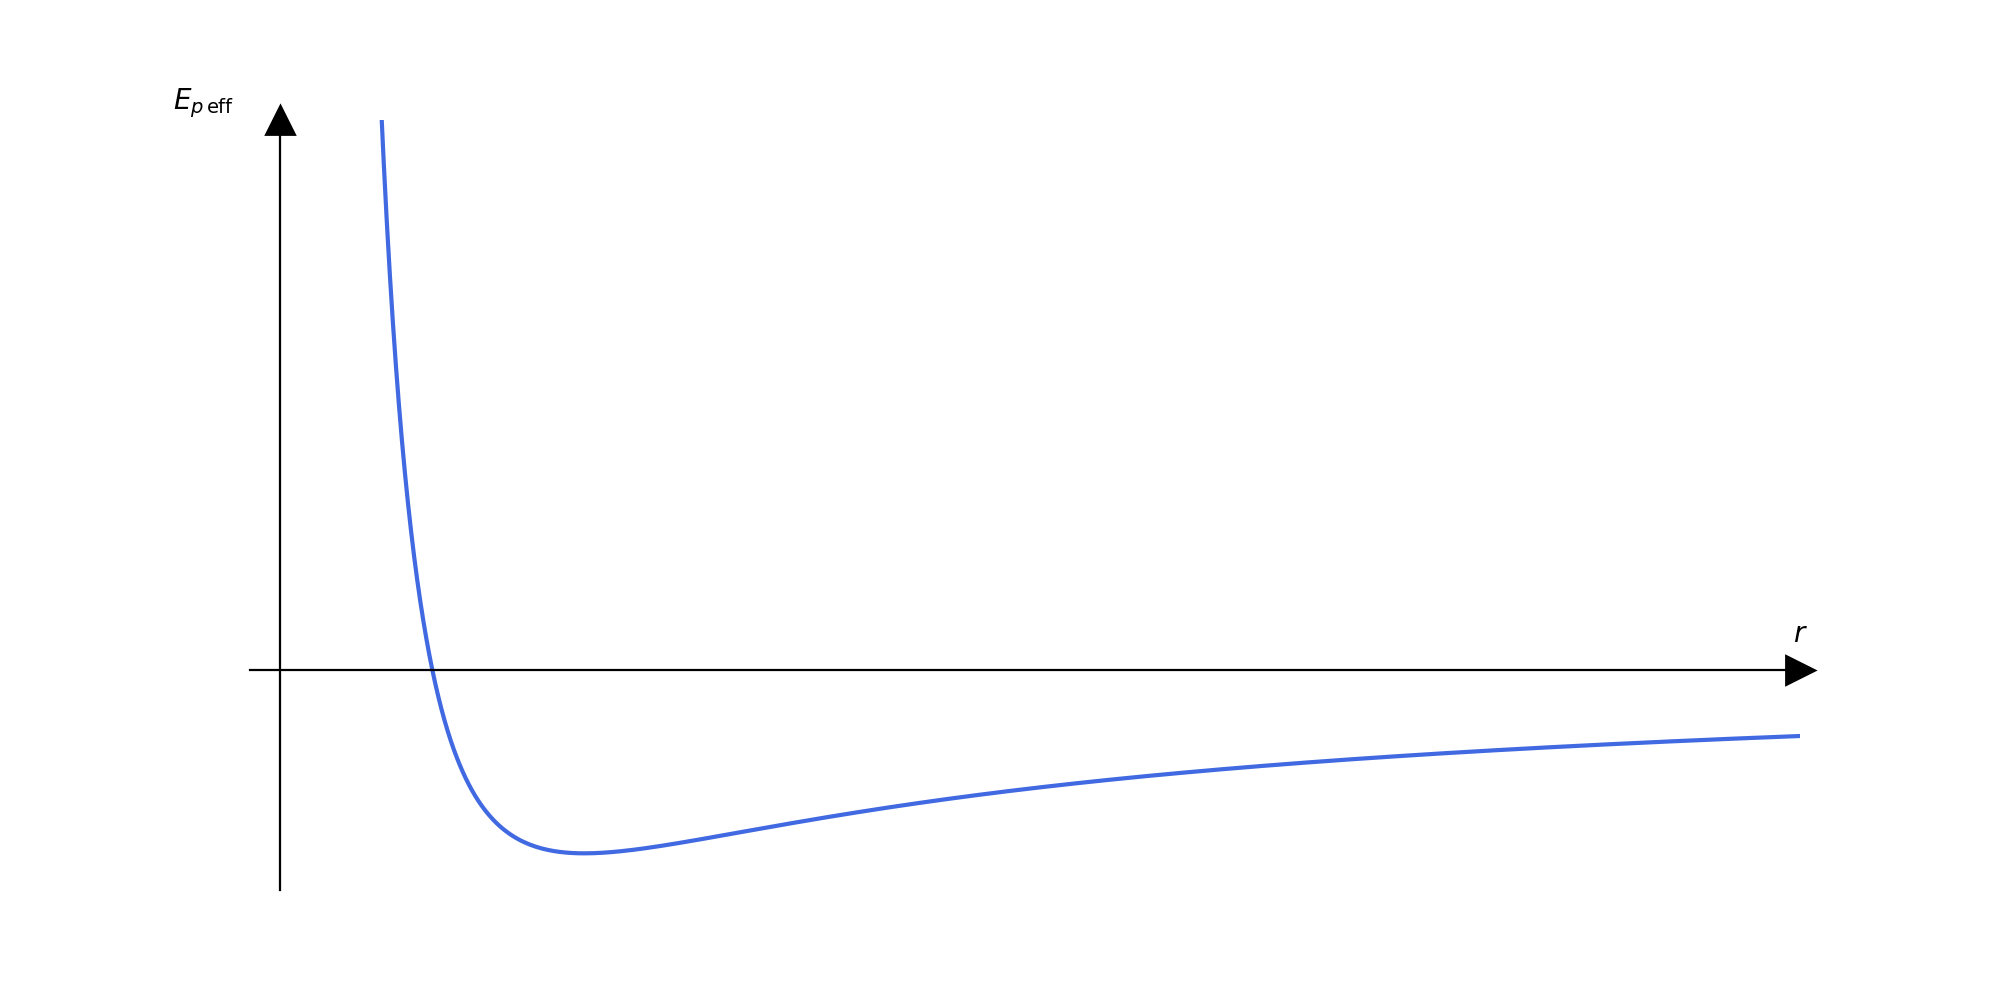

In [147]:
r = np.arange(0.01,10.,0.01)
Epeff = (1. / r**2) - (2. / r)

%matplotlib notebook
fig, ax = plt.subplots()

#Changer la forme des axes
ax.spines['left'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# Faire les flèches
ax.plot((1), (0), ls="", marker=">", ms=10, color="k",transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot((0), (1), ls="", marker="^", ms=10, color="k",transform=ax.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)



plt.xlim(-0.1,5)
plt.ylim(-1.2,3)
    
plt.ylabel('$E_{p\, \mathrm{eff}}$',rotation=0)
plt.xlabel('$r$')

ax.xaxis.set_label_coords(1, 0.35)
ax.yaxis.set_label_coords(-0.03, 1)

ax.plot (r, Epeff, 'royalblue')

plt.savefig('Epeff.pdf',format='pdf', transparent=True)
plt.show()




<IPython.core.display.Javascript object>


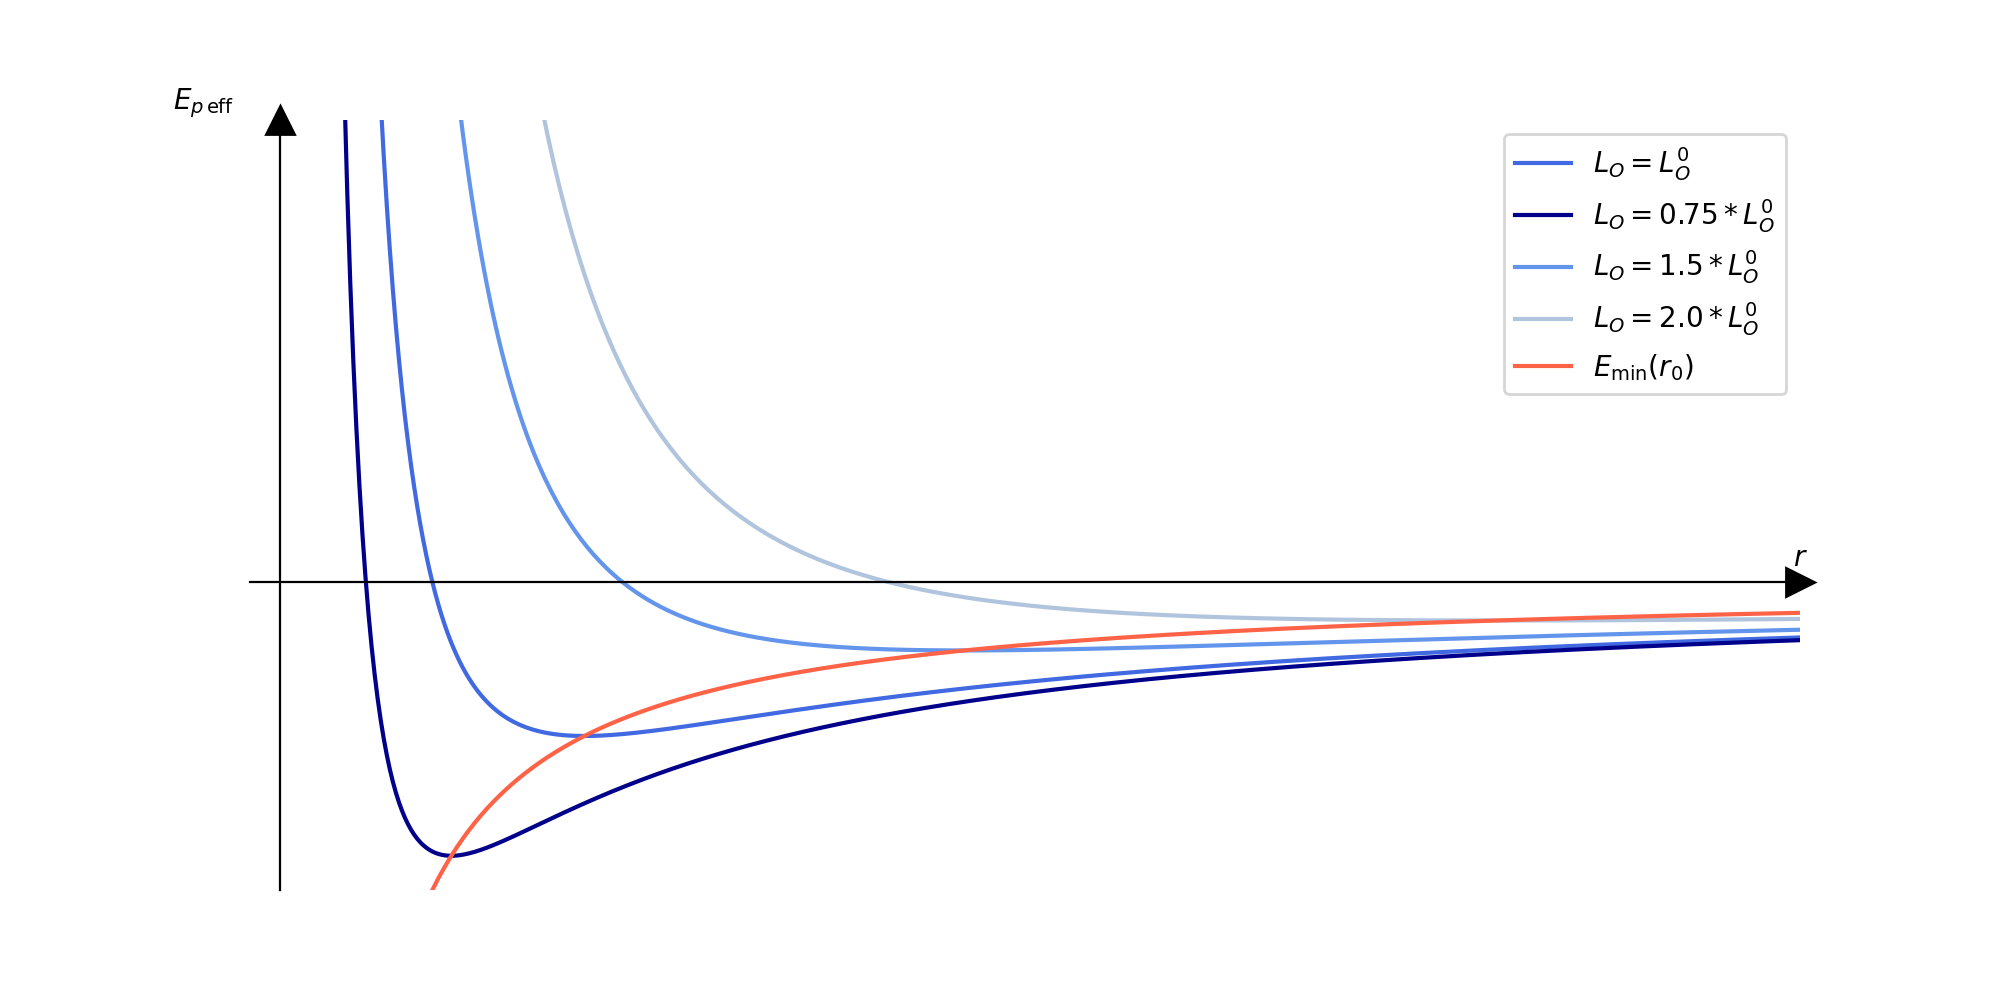

In [33]:
%matplotlib notebook
fig, ax = plt.subplots()

#Changer la forme des axes
ax.spines['left'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# Faire les flèches
ax.plot((1), (0), ls="", marker=">", ms=10, color="k",transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot((0), (1), ls="", marker="^", ms=10, color="k",transform=ax.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)

r = np.arange(0.01,10.,0.01)
Epeff = (1. / r**2) - (2. / r)

    
plt.ylabel('$E_{p\, \mathrm{eff}}$',rotation=0)
plt.xlabel('$r$')

ax.xaxis.set_label_coords(1, 0.45)
ax.yaxis.set_label_coords(-0.03, 1)

ax.plot (r, Epeff, 'royalblue', label='$L_O = L_O^0$')

coeff=0.75
EpeffB =  (coeff**2 / r**2) - (2. / r)
ax.plot (r, EpeffB, 'darkblue', label='$L_O = '+str(coeff)+' * L_O^0$')

coeff=1.5
EpeffB =  (coeff**2 / r**2) - (2. / r)
ax.plot (r, EpeffB, 'cornflowerblue', label='$L_O = '+str(coeff)+' * L_O^0$')

coeff=2.
EpeffB =  (coeff**2 / r**2) - (2. / r)
ax.plot (r, EpeffB, 'lightsteelblue', label='$L_O = '+str(coeff)+' * L_O^0$')

ax.plot (r, -1./r, 'tomato', label='$E_\mathrm{min}(r_0)$')


plt.xlim(-0.1,5)
plt.ylim(-2,3)

plt.legend()


plt.show()


#############################

Trajectoires 

#############################

<IPython.core.display.Javascript object>


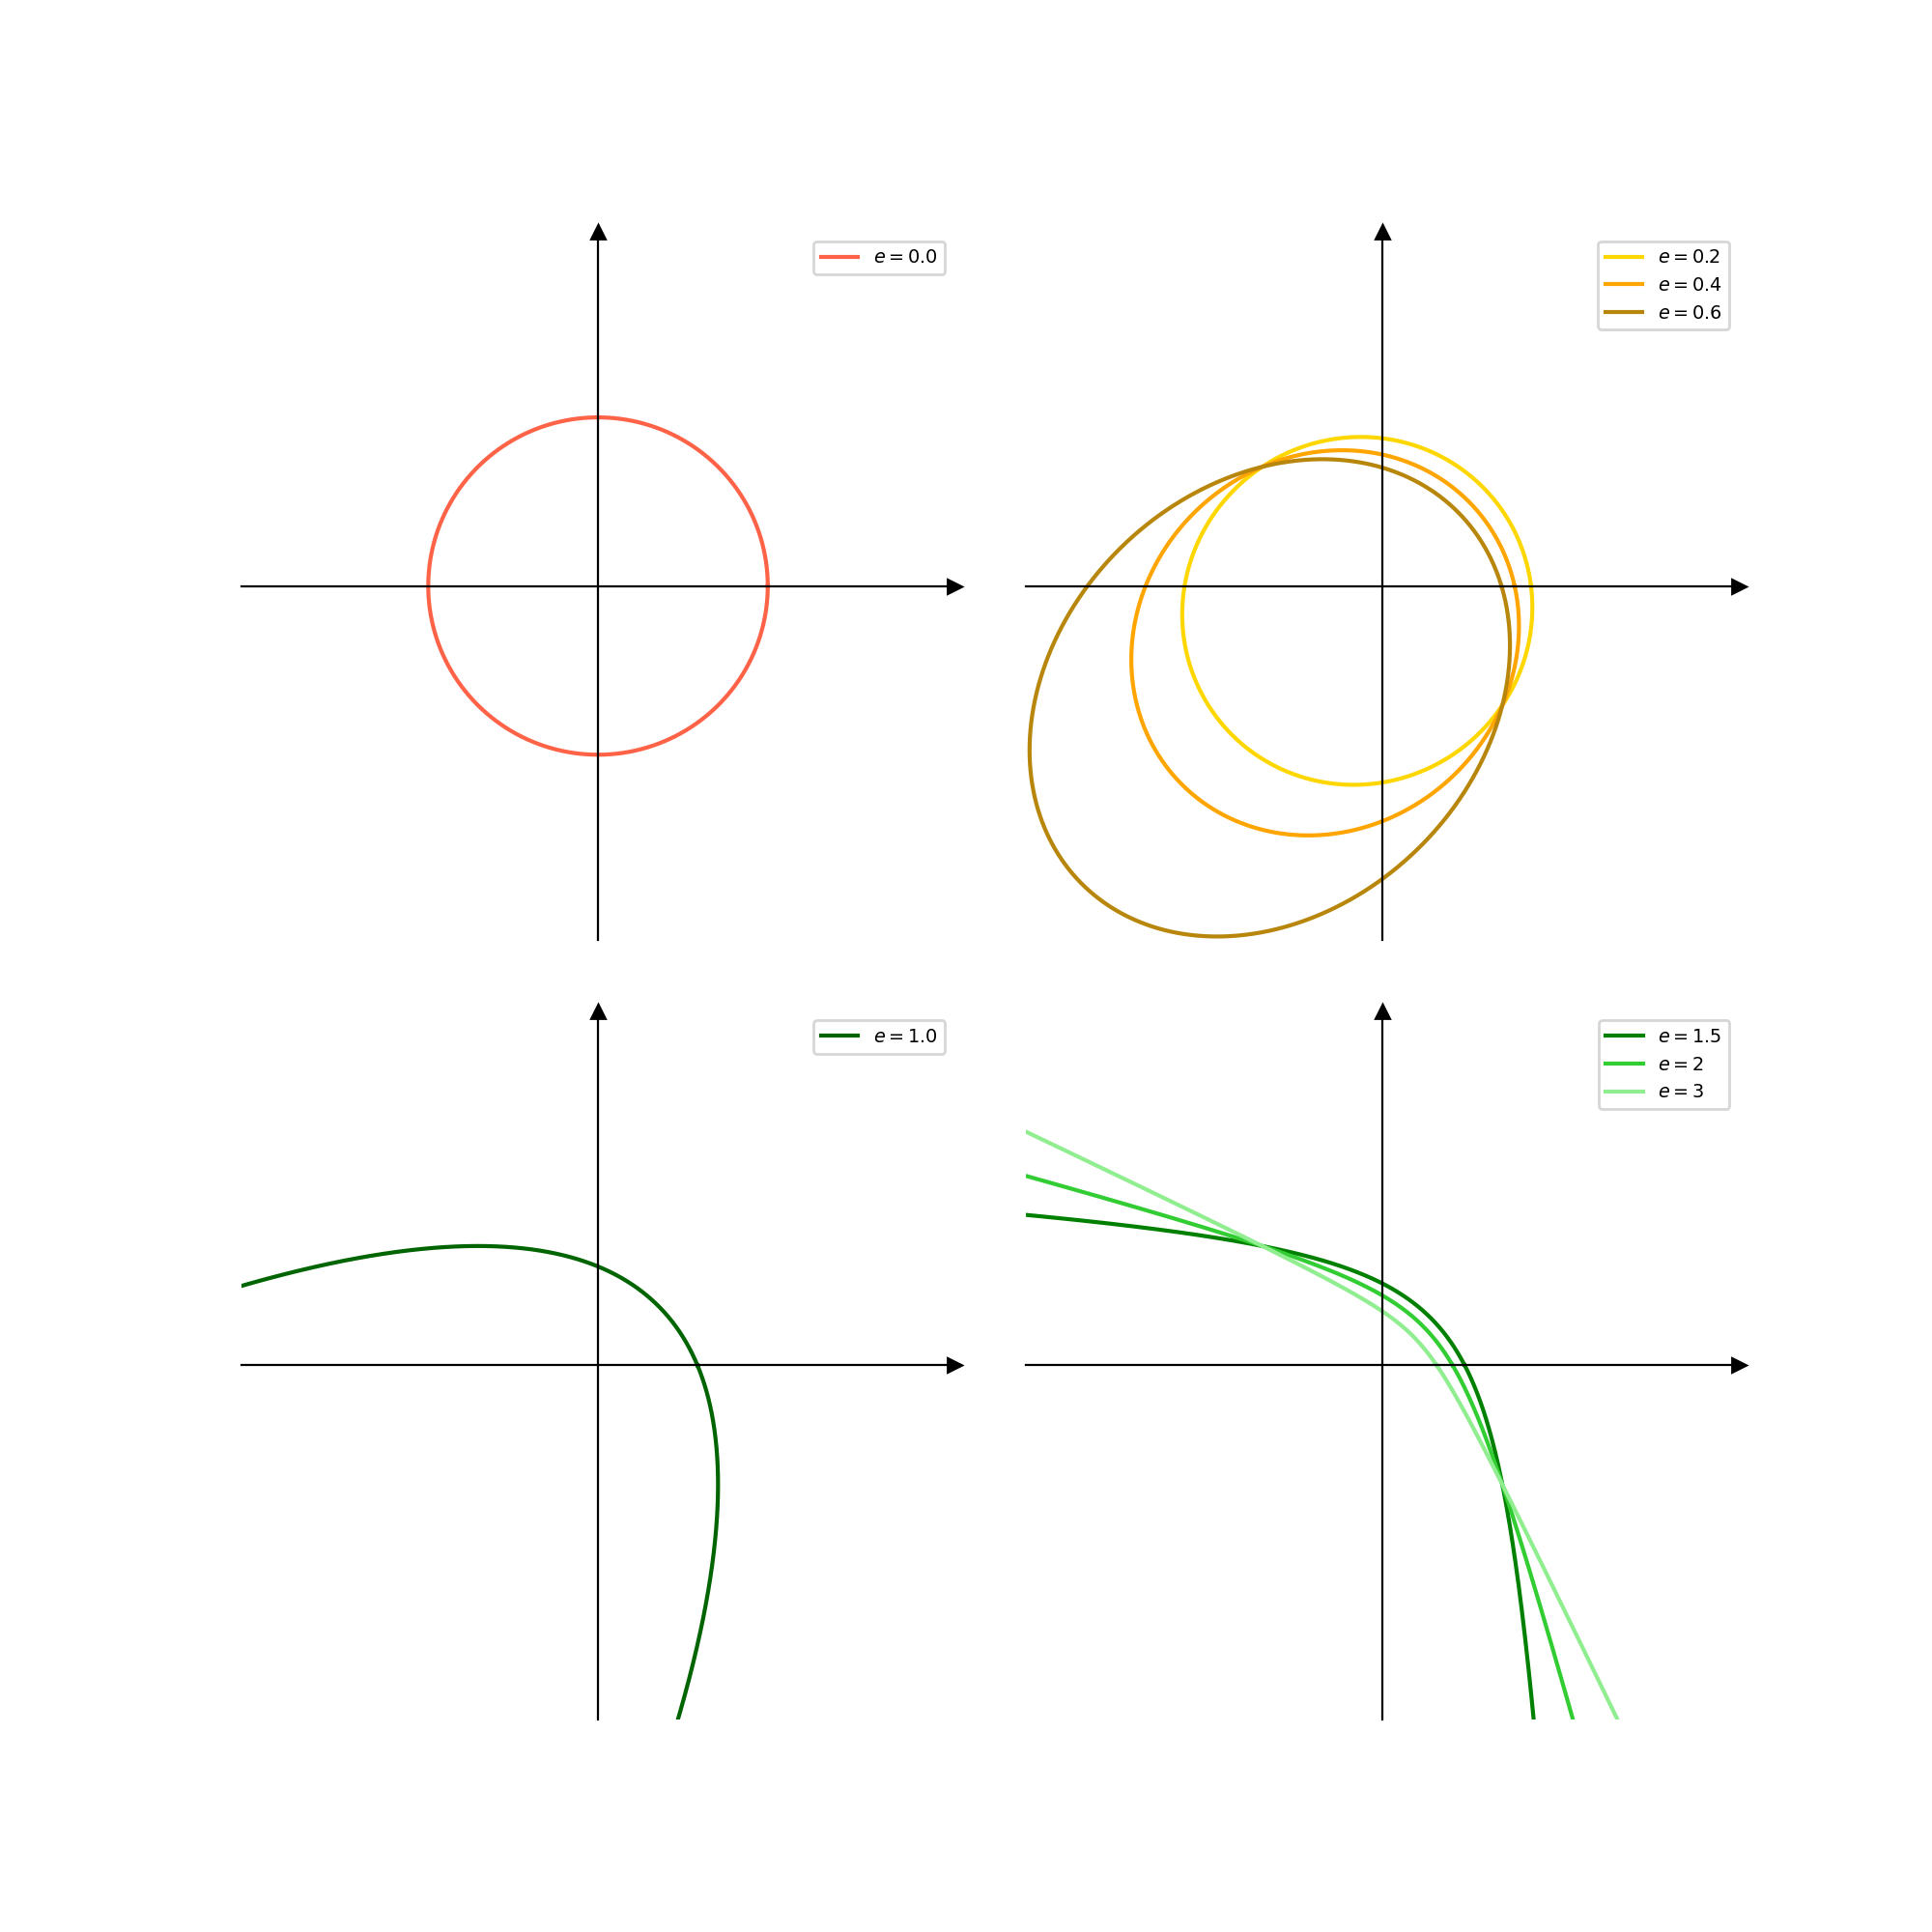

In [144]:
theta = np.arange(0.,2*np.pi, 0.001)
theta0 = np.pi/4.

def rcalc(theta,e) : 
    r = 1. / (1. + e * np.cos(theta - theta0))
    return r


plt.rcParams["figure.figsize"]=10,10
%matplotlib notebook
plt.figure()

borne=2.1

ax1 = plt.subplot(221)

#Changer la forme des axes
ax1.spines['left'].set_position('zero')
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position('zero')
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# Faire les flèches
ax1.plot((1), (0), ls="", marker=">", ms=5, color="k",transform=ax1.get_yaxis_transform(), clip_on=False)
ax1.plot((0), (1), ls="", marker="^", ms=5, color="k",transform=ax1.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)



e=0.
R = rcalc(theta,e)
ax1.plot (R*np.cos(theta), R*np.sin(theta), 'tomato', label='$e=$'+str(e))

plt.legend(fontsize='x-small')

plt.xlim(-borne,borne)
plt.ylim(-borne,borne)



ax2=plt.subplot(222)

#Changer la forme des axes
ax2.spines['left'].set_position('zero')
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position('zero')
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
# Faire les flèches
ax2.plot((1), (0), ls="", marker=">", ms=5, color="k",transform=ax2.get_yaxis_transform(), clip_on=False)
ax2.plot((0), (1), ls="", marker="^", ms=5, color="k",transform=ax2.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)


e=0.2
R = rcalc(theta,e)
ax2.plot (R*np.cos(theta), R*np.sin(theta), 'gold', label='$e=$'+str(e))

e=0.4
R = rcalc(theta,e)
ax2.plot (R*np.cos(theta), R*np.sin(theta), 'orange', label='$e=$'+str(e))

e=0.6
R = rcalc(theta,e)
ax2.plot (R*np.cos(theta), R*np.sin(theta), 'darkgoldenrod', label='$e=$'+str(e))

plt.xlim(-borne,borne)
plt.ylim(-borne,borne)

plt.legend(fontsize='x-small')


ax3=plt.subplot(223)

#Changer la forme des axes
ax3.spines['left'].set_position('zero')
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_position('zero')
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
# Faire les flèches
ax3.plot((1), (0), ls="", marker=">", ms=5, color="k",transform=ax3.get_yaxis_transform(), clip_on=False)
ax3.plot((0), (1), ls="", marker="^", ms=5, color="k",transform=ax3.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)


e=1.
R = rcalc(theta,e)
ax3.plot (R*np.cos(theta), R*np.sin(theta), 'darkgreen', label='$e=$'+str(e))

plt.xlim(-borne,borne)
plt.ylim(-borne,borne)

plt.legend(fontsize='x-small')


ax4=plt.subplot(224)

#Changer la forme des axes
ax4.spines['left'].set_position('zero')
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_position('zero')
ax4.spines['top'].set_visible(False)
ax4.xaxis.set_ticks_position('bottom')
ax4.yaxis.set_ticks_position('left')
# Faire les flèches
ax4.plot((1), (0), ls="", marker=">", ms=5, color="k",transform=ax4.get_yaxis_transform(), clip_on=False)
ax4.plot((0), (1), ls="", marker="^", ms=5, color="k",transform=ax4.get_xaxis_transform(), clip_on=False)

# Cacher les ticks et labels
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
for tick in frame1.axes.get_xticklines():
    tick.set_visible(False)
for tick in frame1.axes.get_yticklines():
    tick.set_visible(False)


e=1.5
R = rcalc(theta,e)
ax4.plot (R[R>=0.]*np.cos(theta[R>=0.]), R[R>=0.]*np.sin(theta[R>=0.]), 'green', label='$e=$'+str(e))

e=2
R = rcalc(theta,e)
ax4.plot (R[R>=0.]*np.cos(theta[R>=0.]), R[R>=0.]*np.sin(theta[R>=0.]), 'limegreen', label='$e=$'+str(e))

e=3
R = rcalc(theta,e)
ax4.plot (R[R>=0.]*np.cos(theta[R>=0.]), R[R>=0.]*np.sin(theta[R>=0.]), 'lightgreen', label='$e=$'+str(e))

plt.xlim(-borne,borne)
plt.ylim(-borne,borne)

plt.legend(fontsize='x-small')

plt.subplots_adjust(wspace=0.1, hspace=0.1) # Ajuster les positions des subplots

plt.show()
